# RC15 Dataset processing
## Clicks-only dataset creation 
This notebook describes pre-processing of clicks data to create reliable datasets.

Both original and reproducibility papers only mention **clicks** and metrics related to clicks,  
however related codebase merge **buys** data to **clicks** data for RC15 dataset. This have  
positive and negative effects. Positive one is that it prolongs some sessions - i.e. adds more  
user actions in form of buy events. On the other hand, buy events are likely not ordered and  
are added to existing sessions as en extra items while it is not clear how were they recorded.  
Buys only represent small portion of data (rc15 has 1,110,965 clicks and only 43,946 buys).  
Moreover, published code treats rewards for clicks and buys  
differently, which is not described in text of the papers. As reasons for merging **buys**  
data to **clicks** dataset is not clear and potentially brings more issues I decided to  
benchmark models with clicks-only dataset.


In [1]:
#!/usr/bin/env python

import os
import pandas as pd
from src.utils import *

import numpy as np
import matplotlib.pyplot as plt

cur_dir = os.getcwd()
data_path = cur_dir + '/div4rec/rc15_data/'
data_path_save = cur_dir + '/div4rec/rc15_data/Clicks_only/'
os.makedirs(data_path_save, exist_ok=True)

### Start with sampled_buys and sampled_clicks
We start with the data produced by sample_data_rc15.py. At least here we copy original work.  
However, we omit sampled_buys.fd and continue with sampled_clicks.df only. Following code    
partially corresponds to merge_and_sort_rc15.py, but we skip merging buys into clicks  
and only sort clicks data.

In [2]:
sampled = pd.read_pickle(os.path.join(data_path, 'sampled_clicks.df'))
sampled_clicks=sampled.drop(columns=['category'])
sampled_clicks['is_buy']=0
sampled_clicks=sampled_clicks.sort_values(by=['session_id','timestamp'])

sampled_clicks.to_csv(f'{data_path_save}sampled_clicks.csv', index = None, header=True)
to_pickled_df(data_path_save, sampled_clicks=sampled_clicks)

#### Calculate item frequencies
We can not use item frequencies from original work as they have changed by omitting buy events.  
Following cell creates less_popular_items.pkl and binary_nov_reward.csv files.

In [3]:
# Get Novel Items
item_freqs = sampled.item_id.value_counts()
threshold = np.quantile(item_freqs, q=0.9)
less_popular_items = []
for i in range(len(item_freqs)):
    if item_freqs.iloc[i] <= threshold:
        less_popular_items.append(item_freqs.index[i])
print('number of less popular items is: ', len(less_popular_items))
with open(f'{data_path_save}less_popular_items.pkl', 'wb') as f:
    pickle.dump(less_popular_items, f)

# Binary Novelty Reward System
for i in range(len(item_freqs)):
    if item_freqs.iloc[i] <= threshold:
        item_freqs.iloc[i] = 1
    else:
        item_freqs.iloc[i] = 0
item_freqs.to_csv(f'{data_path_save}binary_nov_reward.csv', header=False)

number of less popular items is:  24047


### Continue with split_data.py
Almost no changes, we take our sorted clicks data and split it to train, test and val.

In [4]:
total_sessions=sampled_clicks.session_id.unique()
np.random.shuffle(total_sessions)

fractions = np.array([0.8, 0.1, 0.1])
# split into 3 parts
train_ids, val_ids, test_ids = np.array_split(
    total_sessions, (fractions[:-1].cumsum() * len(total_sessions)).astype(int))
train_sessions=sampled_clicks[sampled_clicks['session_id'].isin(train_ids)]
val_sessions=sampled_clicks[sampled_clicks['session_id'].isin(val_ids)]
test_sessions=sampled_clicks[sampled_clicks['session_id'].isin(test_ids)]

to_pickled_df(data_path_save, sampled_train=train_sessions)
to_pickled_df(data_path_save, sampled_val=val_sessions)
to_pickled_df(data_path_save, sampled_test=test_sessions)

### Generate replay buffers for click data
Here we generate replay buffers for test, val and train datasets. Replay buffer  
is source of data further processed before loading by DataLoader.

replay_buffer entry (line) has following format:  
0 &nbsp;&nbsp;&nbsp; [26702, 26702, 26702, 26702, 26702, 26702, 26702, 26702, 26702, 26702]&nbsp;&nbsp;&nbsp; 1 &nbsp; &nbsp; &nbsp; 217 &nbsp;&nbsp;&nbsp; 0 &nbsp;&nbsp;&nbsp; [217, 26702, 26702, 26702, 26702, 26702, 26702, 26702, 26702, 26702] &nbsp;&nbsp;&nbsp; 1 &nbsp;&nbsp;&nbsp; False  
where left to right: line number; **state**; len_state; action; is_buy; **next_state**; len_next_state; is_done  
Note that 26702 is padding item and state is thus empty sequence.

We follow two variants:
 - original approach - buffer contains lines with "empty" **state** (only padding items) - see replay buffer example above  
   - this approach is defined by skip parameter set to skip=0 (minimal sequence length is zero)
 - improved approach - 1st state in buffer already contains one or more items
   - skip parameter is 1 or 2, i.e. minimal sequence length is 1 or 2

Explainer: with original approach all buffers contain lines with no item in **state** and  
single item in **next_state**. That means model should guess first item during inference  
and consequently some metrics (as hit ration) are affected by considering these random guesses.  
My estimation is that 10 - 20 % of entries in replay buffers are of this kind and I expect that  
having around 26700 items it leads to truly random guesses. Improved dataset will eliminate  
situations when model should infer (guess) based on empty (paddings only) sequence. Training  
may also be negatively affected by empty states in training data.

In [6]:
state_size, item_num = get_stats(data_path)

def create_buffer(dataset_name, sorted_events, output_path, skip_length=0):
    pad_item = item_num
    groups = sorted_events.groupby('session_id')
    ids = sorted_events.session_id.unique()

    state, len_state, action, is_buy, next_state, len_next_state, is_done = [], [], [], [], [],[],[]
    statis_items = set()
    statis_sessions = {}
    statis_entries = 0

    for id in ids:
        group = groups.get_group(id)
        history = []
        counter=1
        for index, row in group.iterrows():
            s = list(history)
            len_s = state_size if len(s) >= state_size else 1 if len(s) == 0 else len(s)
            s = pad_history(s, state_size, pad_item)
            a = row['item_id']
            is_b = row['is_buy']
            history.append(row['item_id'])
            next_s = list(history)
            len_ns = state_size if len(next_s) >= state_size else 1 if len(next_s) == 0 else len(next_s)
            next_s=pad_history(next_s, state_size, pad_item)
            # sequences of skip_length or shorter are not added to dataset
            if counter > skip_length:
                state.append(s)
                len_state.append(len_s)
                action.append(a)
                is_buy.append(is_b)
                len_next_state.append(len_ns)
                next_state.append(next_s)
                is_done.append(False)
                statis_entries += 1
            counter+=1
            statis_items.add(a)
        count = counter - 1
        statis_sessions[count] = statis_sessions.get(count, 0) + 1
        is_done[-1] = True
    sum_statis_items = {"item_num": len(statis_items)}
    sum_statis_entries = {"entries_num": statis_entries}
    sorted_statis_sessions = {k: statis_sessions[k] for k in sorted(statis_sessions)}

    replay_buffer_dict = {
        'state': state,
        'len_state': len_state,
        'action': action,
        'is_buy': is_buy,
        'next_state': next_state,
        'len_next_states': len_next_state,
        'is_done': is_done
    }
    replay_buffer = pd.DataFrame(data=replay_buffer_dict)
    replay_buffer.to_pickle(output_path + f'replay_buffer_{dataset_name}_skip={skip_length}.df')
    with open(output_path + 'sessions_stats.df', "wb") as f:
        pickle.dump(sorted_statis_sessions, f)
        #sorted_statis_sessions.to_pickle(output_path + 'sessions_stats.df')
    with open(output_path + 'items_stats.df', "wb") as f:
        pickle.dump(sum_statis_items, f)
        #sum_statis_items.to_pickle(output_path + 'items_stats.df')
    with open(output_path + 'entries_stats.df', "wb") as f:
        pickle.dump(sum_statis_entries, f)
    

Note, that function create_buffer defined above compute some data statistics. Namely, number of different items  
in new dataset, populations of session lengths and number of entries per dataset.

To create replay buffers, run following cell:  

In [7]:
for dataset in ['val', 'test', 'train']:
    sorted_events = pd.read_pickle(data_path_save + f'sampled_{dataset}.df')
    for skip in [0, 1, 2]:
        newpath = data_path_save + f'{dataset}_skip_{skip}/'
        os.makedirs(newpath, exist_ok=True)
        create_buffer(dataset, sorted_events, newpath, skip)

### New Datasets Statistics

Print info about datasets with following cell:

SET:  val SKIP:  0
ITEMS:  13337
ENTRIES:  112246
SESSIONS Lengths Populations:  {3: 7336, 4: 4121, 5: 2389, 6: 1631, 7: 1095, 8: 810, 9: 546, 10: 411, 11: 310, 12: 249, 13: 182, 14: 119, 15: 124, 16: 113, 17: 77, 18: 60, 19: 52, 20: 39, 21: 36, 22: 37, 23: 25, 24: 21, 25: 20, 26: 17, 27: 23, 28: 13, 29: 17, 30: 12, 31: 7, 32: 7, 33: 10, 34: 9, 35: 8, 36: 10, 37: 2, 38: 4, 39: 1, 40: 4, 41: 6, 42: 2, 43: 3, 44: 2, 45: 3, 47: 3, 49: 3, 50: 3, 51: 1, 52: 2, 53: 1, 54: 1, 55: 2, 56: 2, 58: 2, 59: 5, 63: 1, 65: 1, 66: 1, 68: 2, 69: 1, 71: 2, 76: 1, 87: 1, 116: 1, 193: 1}
SET:  val SKIP:  1
ITEMS:  13337
ENTRIES:  92246
SESSIONS Lengths Populations:  {3: 7336, 4: 4121, 5: 2389, 6: 1631, 7: 1095, 8: 810, 9: 546, 10: 411, 11: 310, 12: 249, 13: 182, 14: 119, 15: 124, 16: 113, 17: 77, 18: 60, 19: 52, 20: 39, 21: 36, 22: 37, 23: 25, 24: 21, 25: 20, 26: 17, 27: 23, 28: 13, 29: 17, 30: 12, 31: 7, 32: 7, 33: 10, 34: 9, 35: 8, 36: 10, 37: 2, 38: 4, 39: 1, 40: 4, 41: 6, 42: 2, 43: 3, 44: 2, 45: 3, 47

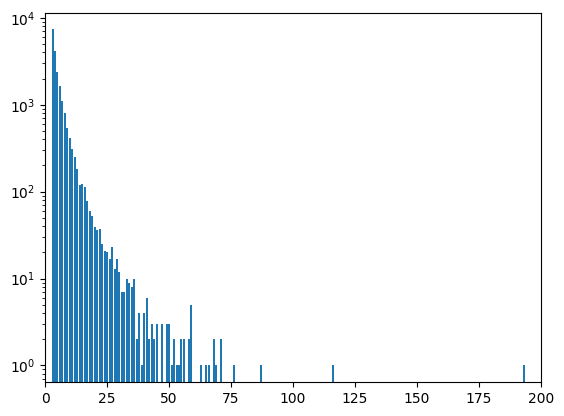

SET:  test SKIP:  0
ITEMS:  13056
ENTRIES:  110052
SESSIONS Lengths Populations:  {3: 7276, 4: 4253, 5: 2479, 6: 1621, 7: 1080, 8: 774, 9: 536, 10: 379, 11: 296, 12: 267, 13: 172, 14: 151, 15: 120, 16: 88, 17: 62, 18: 75, 19: 38, 20: 43, 21: 32, 22: 34, 23: 23, 24: 23, 25: 25, 26: 14, 27: 13, 28: 10, 29: 14, 30: 11, 31: 10, 32: 7, 33: 10, 34: 8, 35: 3, 36: 2, 37: 4, 38: 4, 39: 4, 40: 6, 41: 2, 42: 4, 43: 2, 45: 1, 47: 2, 48: 2, 49: 3, 50: 1, 52: 1, 55: 2, 58: 1, 59: 2, 62: 1, 63: 1, 64: 2, 66: 1, 68: 1, 74: 2, 91: 1, 123: 1}
SET:  test SKIP:  1
ITEMS:  13056
ENTRIES:  90052
SESSIONS Lengths Populations:  {3: 7276, 4: 4253, 5: 2479, 6: 1621, 7: 1080, 8: 774, 9: 536, 10: 379, 11: 296, 12: 267, 13: 172, 14: 151, 15: 120, 16: 88, 17: 62, 18: 75, 19: 38, 20: 43, 21: 32, 22: 34, 23: 23, 24: 23, 25: 25, 26: 14, 27: 13, 28: 10, 29: 14, 30: 11, 31: 10, 32: 7, 33: 10, 34: 8, 35: 3, 36: 2, 37: 4, 38: 4, 39: 4, 40: 6, 41: 2, 42: 4, 43: 2, 45: 1, 47: 2, 48: 2, 49: 3, 50: 1, 52: 1, 55: 2, 58: 1, 59:

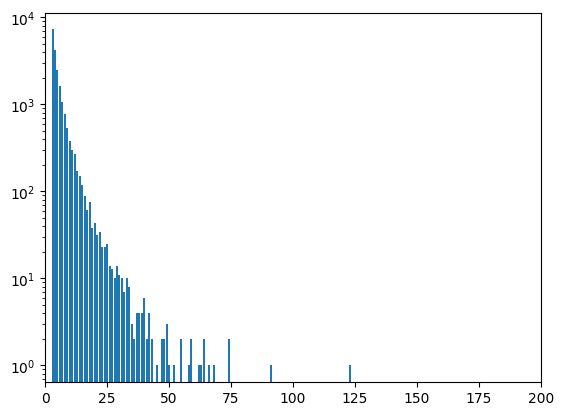

SET:  train SKIP:  0
ITEMS:  25433
ENTRIES:  888667
SESSIONS Lengths Populations:  {3: 58418, 4: 33891, 5: 19540, 6: 12940, 7: 8566, 8: 6051, 9: 4282, 10: 3216, 11: 2477, 12: 1917, 13: 1447, 14: 1196, 15: 970, 16: 695, 17: 661, 18: 476, 19: 443, 20: 368, 21: 276, 22: 247, 23: 200, 24: 175, 25: 170, 26: 131, 27: 127, 28: 104, 29: 100, 30: 93, 31: 78, 32: 62, 33: 56, 34: 56, 35: 53, 36: 41, 37: 43, 38: 34, 39: 31, 40: 34, 41: 20, 42: 24, 43: 11, 44: 15, 45: 11, 46: 14, 47: 14, 48: 13, 49: 10, 50: 17, 51: 5, 52: 13, 53: 13, 54: 6, 55: 7, 56: 12, 57: 8, 58: 5, 59: 6, 60: 6, 61: 4, 62: 3, 63: 2, 64: 7, 65: 8, 66: 6, 67: 7, 68: 5, 69: 3, 71: 1, 72: 2, 73: 4, 74: 3, 75: 1, 76: 4, 78: 5, 79: 3, 81: 1, 82: 2, 83: 1, 84: 3, 85: 1, 86: 2, 87: 1, 88: 1, 89: 1, 90: 4, 92: 2, 93: 1, 95: 1, 96: 2, 98: 3, 99: 1, 102: 1, 121: 1, 124: 1, 125: 1, 135: 1, 149: 1, 151: 1, 160: 1, 193: 1, 197: 1}
SET:  train SKIP:  1
ITEMS:  25433
ENTRIES:  728667
SESSIONS Lengths Populations:  {3: 58418, 4: 33891, 5: 19540

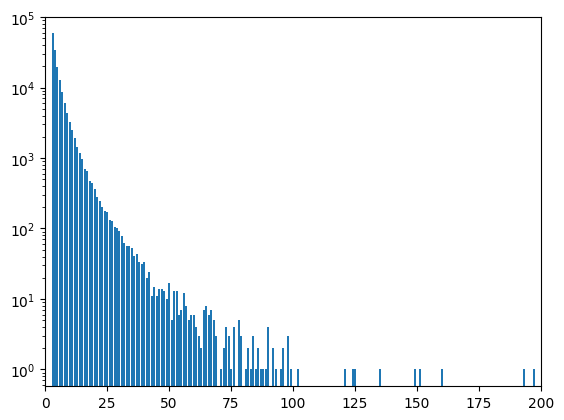

In [8]:
for dataset in ['val', 'test', 'train']:
    sorted_events = pd.read_pickle(data_path_save + f'sampled_{dataset}.df')
    for skip in [0, 1, 2]:
        newpath = data_path_save + f'{dataset}_skip_{skip}/'
        sessions_stats = pd.read_pickle(os.path.join(newpath, 'sessions_stats.df'))
        items_stats = pd.read_pickle(os.path.join(newpath, 'items_stats.df'))
        entries_stats = pd.read_pickle(os.path.join(newpath, 'entries_stats.df'))
        print('SET: ', dataset, 'SKIP: ', skip)
        print('ITEMS: ', items_stats["item_num"])
        print('ENTRIES: ', entries_stats["entries_num"])
        print('SESSIONS Lengths Populations: ', sessions_stats)
        
    x = list(sessions_stats.keys())
    y = list(sessions_stats.values())
    plt.bar(x, y)
    plt.yscale("log")
    plt.xlim((0,200))
    plt.show()

In [9]:
check_df = pd.read_pickle(data_path_save + "test_skip_0/replay_buffer_test_skip=0.df")
check_df.head(20)

,state,len_state,action,is_buy,next_state,len_next_states,is_done
0,"[26702, 26702, 26702, 26702, 26702, 26702, 267...",1,21604,0,"[21604, 26702, 26702, 26702, 26702, 26702, 267...",1,False
1,"[21604, 26702, 26702, 26702, 26702, 26702, 267...",1,18554,0,"[21604, 18554, 26702, 26702, 26702, 26702, 267...",2,False
2,"[21604, 18554, 26702, 26702, 26702, 26702, 267...",2,18343,0,"[21604, 18554, 18343, 26702, 26702, 26702, 267...",3,False
3,"[21604, 18554, 18343, 26702, 26702, 26702, 267...",3,18422,0,"[21604, 18554, 18343, 18422, 26702, 26702, 267...",4,True
4,"[26702, 26702, 26702, 26702, 26702, 26702, 267...",1,19970,0,"[19970, 26702, 26702, 26702, 26702, 26702, 267...",1,False
5,"[19970, 26702, 26702, 26702, 26702, 26702, 267...",1,19971,0,"[19970, 19971, 26702, 26702, 26702, 26702, 267...",2,False
6,"[19970, 19971, 26702, 26702, 26702, 26702, 267...",2,19971,0,"[19970, 19971, 19971, 26702, 26702, 26702, 267...",3,False
7,"[19970, 19971, 19971, 26702, 26702, 26702, 267...",3,19970,0,"[19970, 19971, 19971, 19970, 26702, 26702, 267...",4,False
8,"[19970, 19971, 19971, 19970, 26702, 26702, 267...",4,18659,0,"[19970, 19971, 19971, 19970, 18659, 26702, 267...",5,False
9,"[19970, 19971, 19971, 19970, 18659, 26702, 267...",5,16372,0,"[19970, 19971, 19971, 19970, 18659, 16372, 267...",6,False
